In [144]:
from torchvision import models, transforms
import torch
import os
from PIL import Image
import shutil
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [143]:
path = input('Enter a full path of your PC: ')
extensions = ['.png', '.jpeg', '.jpg']

Enter a full path of your PC: /content/papka


In [ ]:
for root, dirs, files in os.listdir(path):
  for i in files:
    name, ext = os.path.splitext(i)
    if ext in extensions:
      shutil.copy(os.path.join(root, i), temp_repo)

In [137]:
model = models.resnet18(pretrained=True)
feature_layer = model._modules.get('avgpool')
model.eval()
torch.device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(torch.device)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

def get_feature_vector(img):
  transformed_img = transform(img).unsqueeze(0)
  result_vector = torch.zeros(1, 512, 1, 1)

  
  def copy_output(module, input, output):
    result_vector.copy_(output.data)
  
  hook = feature_layer.register_forward_hook(copy_output)
  model(transformed_img)    
  hook.remove()
  
  return result_vector.numpy()[0, :, 0, 0]

allVectors = {}
for image in tqdm(os.listdir(temp_repo)):
  I = Image.open(os.path.join(temp_repo, image)).convert('RGB')
  vector = get_feature_vector(I)
  allVectors[image] = vector
  I.close()
shutil.rmtree(temp_repo)        

100%|██████████| 42/42 [00:05<00:00,  7.99it/s]


In [146]:
def CosineSimilarity(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix
        
similarity_matrix = CosineSimilarity(allVectors)

,00000001.jpg,00000003_(3).jpg,00000000_(5).jpg,00000001_(7).jpg,00000002_(6).jpg,00000003_(5).jpg,00000004_(7).jpg,00000003_(4).jpg,00000001_(2).jpg,SeasonalRank5-4.png,00000002_(3).jpg,praktikum.JPG,ddc7rir-c84fe1a8-84a2-4e96-a191-afc2a6673013.jpg,00000003_(6).jpg,00000000_(2).jpg,bart.jpg,00000004_(3).jpg,00000000.jpg,00000002.jpg,00000004_(2).jpg,00000002_(2).jpg,00000001_(3).jpg,00000003_(7).jpg,00000002_(4).jpg,00000000_(6).jpg,00000004_(6).jpg,hHztxHwgFPA.jpg,fen.jpg,00000001_(4).jpg,00000000_(7).jpg,00000002_(5).jpg,00000004.jpg,00000004_(4).jpg,00000001_(6).jpg,00000000_(3).jpg,rycar-iz-kompyutornoy-igry_1920x1080.jpg,00000003_(2).jpg,00000000_(4).jpg,00000003.jpg,00000001_(5).jpg,maxresdefault.jpg,00000004_(5).jpg
00000001.jpg,1.000000,0.605815,0.624317,0.691976,0.666296,0.686168,0.809486,0.682991,0.737878,0.483946,0.804082,0.323251,0.520018,0.709916,0.610654,0.438459,0.660570,0.891331,0.706554,0.643582,0.717698,0.741522,0.662713,0.648860,0.746288,0.687517,0.503709,0.533927,0.595530,0.690266,0.633327,0.791083,0.597638,0.686334,0.662819,0.530639,0.686168,0.586221,0.643582,0.696293,0.568577,0.490264
00000003_(3).jpg,0.605815,1.000000,0.591749,0.762685,0.594970,0.717166,0.635315,0.726032,0.629966,0.506158,0.602600,0.323460,0.628378,0.695424,0.617967,0.506978,0.669050,0.593498,0.629877,0.613995,0.688590,0.631158,0.640403,0.702944,0.635404,0.651955,0.531413,0.527400,0.590539,0.659229,0.791078,0.604757,0.656040,0.695071,0.612851,0.600826,0.717166,0.584910,0.613995,0.677323,0.569403,0.531867
00000000_(5).jpg,0.624317,0.591749,1.000000,0.611257,0.574525,0.706148,0.645327,0.719004,0.755192,0.476746,0.643328,0.417534,0.493019,0.710695,0.703617,0.467678,0.610721,0.611231,0.672028,0.769880,0.743654,0.536909,0.720127,0.715763,0.769433,0.552670,0.549252,0.515295,0.532672,0.738139,0.603619,0.692343,0.616202,0.752342,0.687584,0.523918,0.706148,0.552933,0.769880,0.796026,0.571813,0.586892
00000001_(7).jpg,0.691976,0.762685,0.611257,1.000000,0.644105,0.717882,0.678167,0.746425,0.739861,0.534508,0.683396,0.395313,0.632769,0.712465,0.621647,0.491982,0.700825,0.668577,0.679842,0.590139,0.762567,0.720872,0.600515,0.648436,0.715664,0.673481,0.532957,0.577863,0.611011,0.667769,0.769844,0.654838,0.623553,0.734767,0.649013,0.627630,0.717882,0.587968,0.590139,0.695327,0.590747,0.508040
00000002_(6).jpg,0.666296,0.594970,0.574525,0.644105,1.000000,0.680098,0.729277,0.663790,0.558992,0.472440,0.777482,0.323453,0.571995,0.594217,0.590899,0.441518,0.713777,0.687905,0.636649,0.578179,0.616503,0.819739,0.740115,0.587972,0.655057,0.765373,0.494517,0.490241,0.723144,0.717004,0.570375,0.705363,0.537695,0.612170,0.806821,0.558954,0.680098,0.758018,0.578179,0.594004,0.507878,0.444208
00000003_(5).jpg,0.686168,0.717166,0.706148,0.717882,0.680098,1.000000,0.712507,0.775806,0.772085,0.521811,0.673703,0.357127,0.614664,0.729373,0.809887,0.501739,0.700446,0.676547,0.725649,0.726939,0.773644,0.692359,0.736691,0.736935,0.732657,0.715499,0.586636,0.563213,0.598445,0.793266,0.709032,0.682712,0.663614,0.811910,0.711728,0.618442,1.000000,0.589299,0.726939,0.692302,0.590697,0.570039
00000004_(7).jpg,0.809486,0.635315,0.645327,0.678167,0.729277,0.712507,1.000000,0.687725,0.669833,0.513075,0.856274,0.378311,0.613595,0.678950,0.630338,0.531561,0.664160,0.791776,0.779466,0.666815,0.687701,0.754982,0.731299,0.686250,0.754357,0.721441,0.530752,0.584572,0.646667,0.738691,0.631419,0.783998,0.622371,0.686420,0.724933,0.560062,0.712507,0.667612,0.666815,0.689842,0.622298,0.595020
00000003_(4).jpg,0.682991,0.726032,0.719004,0.746425,0.663790,0.775806,0.687725,1.000000,0.783367,0.555245,0.696535,0.359480,0.605465,0.777351,0.710805,0.512454,0.769580,0.672846,0.680370,0.730278,0.799555,0.671754,0.677328,0.743792,0.771542,0.700167,0.612860,0.544617,0.611178,0.739176,0.734233,0.665146,0.687667,0.796937,0.739818,0.634104,0.775806,0.614980,0.730278,0.790193,0.594266,0.587543
00000001_(2).jpg,0.737878,0.629966,0.755192,0.739861,0.558992,0.772085,0.669833,0.783367,1.000000,0.466265,0.6

In [252]:
def require_similar_images():
  required_img = input('Choose the input image: ')
  df = similarity_matrix[required_img].sort_values(ascending=False).iloc[:][1:6]
  filenames = df.index
  values = df.values

  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30,10))
  query = Image.open(os.path.join(temp_repo, required_img))
  ax1.imshow(query, aspect='auto')
  ax1.set_xlabel('Initial image', fontsize = 20)
  ax1.set_yticks([])
  ax1.set_xticks([])


  for name, value, ax in zip(filenames, values, [ax2, ax3, ax4, ax5]):
    img = Image.open(os.path.join(temp_repo, name))
    ax.imshow(img, aspect='auto')
    ax.set_ylabel('Similar image:{}'.format(name), fontsize=12)
    ax.set_xlabel('Similarity: {:.2%}'.format(value), fontsize=20)
    ax.set_yticks([])
    ax.set_xticks([])

  plt.show()

Enter the input image: 00000004.jpg


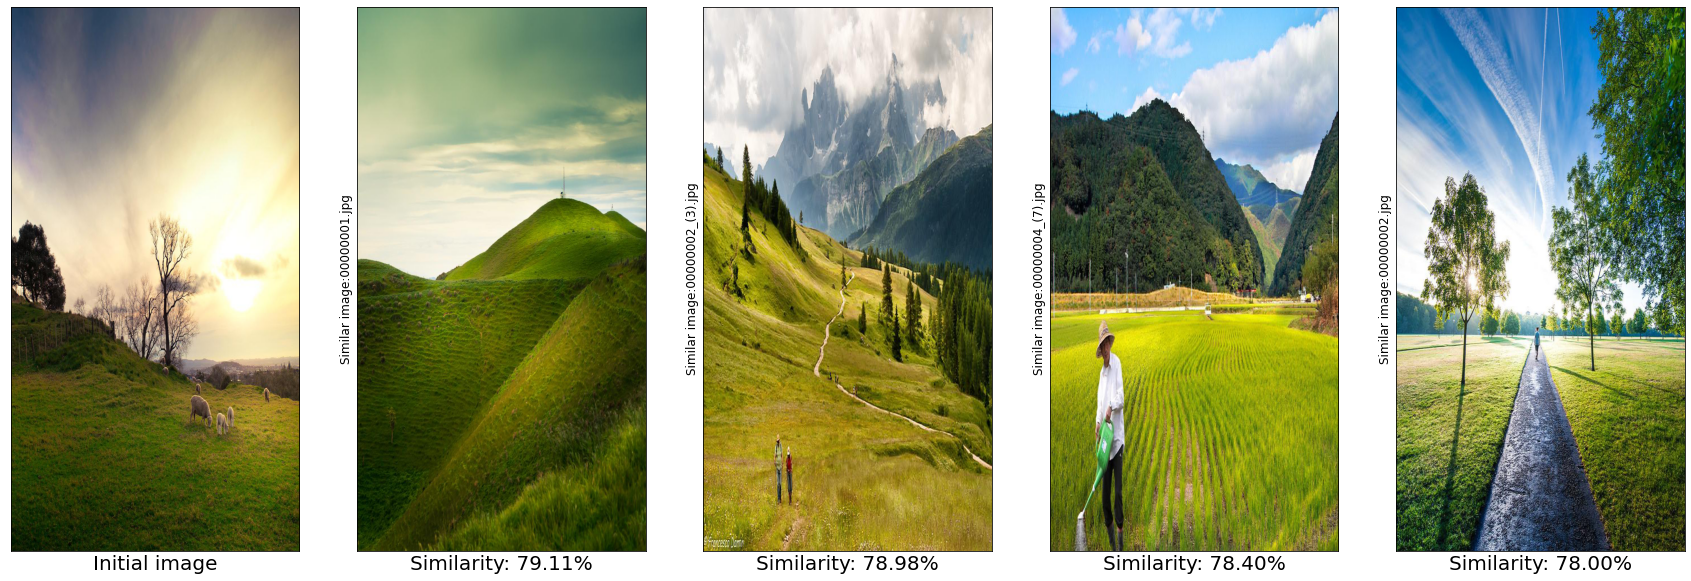

In [254]:
require_similar_images()

In [ ]:
shutil